In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import json
import os
from collections import Counter

from time import time

%matplotlib inline

import scipy.sparse

In [1]:
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
matplotlib.rc('axes', labelsize='large') 

In [2]:
def id_counter(id_list):
    cnt = Counter()
    for el in id_list:
        cnt[el[u'element']] = el[u'count']
    return cnt

def_black_list = { 'unit', 'units', 'value', 'values', 'axis', 'axes', 'factor', 'factors', 'line', 'lines',
                 'point', 'points', 'number', 'numbers', 'variable', 'variables', 'respect', 'case', 'cases',
                 'vector', 'vectors', 'element', 'elements', 'example', 
                 'integer', 'integers', 'term', 'terms', 'parameter', 'parameters', 'coefficient', 'coefficients',
                 'formula', 'times', 'product', 'matrices', 'expression', 'complex', 'real', 'zeros', 'bits',
                 'sign',
                 'if and only if',
                 'alpha', 'beta', 'gamma', 'delta', 'epsilon', 'zeta', 'eta', 'theta', 'iota', 'kappa', 'lambda', 
                 'mu', 'nu', 'xi', 'omicron', 'pi', 'rho', 'sigma', 'tau', 'upsilon', 'phi', 'chi', 'psi', 'omega'}

def valid_def(definition):
    if len(definition) <= 3:
        return False

    return definition.lower() not in def_black_list

def rel_to_dict(rels):
    res = defaultdict(list)
    for r in rels:
        if not valid_def(r['definition']):
            continue
        res[r['identifier']].append((r['definition'], r['score']))
    return res

In [3]:
from collections import defaultdict

doc_categories = defaultdict(set)
category_docs = defaultdict(set)

for line in file('C:/tmp/mlp/category_info_refined.txt'):
    title, cat = line.strip().split('\t')
    title = title.decode('utf-8')
    cat = cat.decode('utf-8')

    # let's also remove all documents from "OTHER" category
    if cat == u'OTHER':
        continue

    doc_categories[title].add(cat) 
    category_docs[cat].add(title)

In [6]:
root = 'C:/tmp/mlp/mlp-output/'

docs = []
titles = []
ids = []
rels = []

empty = 0
small = 0
uncategorized = 0

for f in os.listdir(root): 
    for line in file(root + f):
        doc = json.loads(line)

        title = doc['title']        
        if title not in doc_categories:
            uncategorized = uncategorized + 1
            continue

        if '(disambiguation)' in title:
            continue

        id_bag = id_counter(doc['identifiers'])
        if len(id_bag) <= 1:
            if len(id_bag) == 0:
                empty = empty + 1
            else:
                small = small + 1
            continue

        docs.append(doc)
        titles.append(title)
        ids.append(id_bag)

        id_rels = rel_to_dict(doc['relations'])
        rels.append(id_rels)

print empty, small, uncategorized

N_doc = len(ids)
print N_doc

0 0 7501
22512


## Is Power law test

In [9]:
cnt = Counter()

for id_list in ids:
    cnt.update(id_list)

In [10]:
cnt_pd = pd.Series(cnt.values())
cnt_pd.sort(ascending=0, inplace=1)

In [12]:
cnt_pd.head()

5612     125514
4255     109454
2328     105728
10392     83983
4954      77913
dtype: int64


Simple

In [33]:
import statsmodels.api as sm

In [28]:
x = np.arange(len(cnt_pd)) + 1
px = cnt_pd.values * 1.0 / cnt_pd.sum()

In [29]:
log_x = np.log(x)
log_px = np.log(px)

In [36]:
model = sm.OLS(log_px, sm.add_constant(log_x)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                 6.168e+05
Date:                Wed, 20 Jan 2016   Prob (F-statistic):               0.00
Time:                        19:55:51   Log-Likelihood:                 432.69
No. Observations:               12771   AIC:                            -861.4
Df Residuals:                   12769   BIC:                            -846.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          0.8821      0.018     49.945      0.000         0.847     0.917
x1            -1.6291      0.002   -785.372      0.000        -1.633    -1.625
==============================================================================
Omnibus:                     3734.119   Durbin-Watson:                   0.004
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            25312.449
Skew:                          -1.231   Prob(JB):                         0.00
Kurtosis:                       9.443   Cond. No.                         73.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

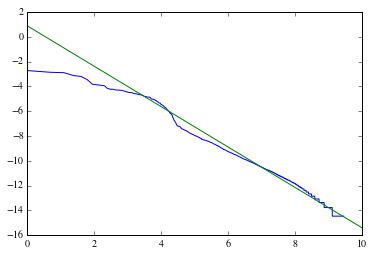

In [47]:
ax = plt.gca()

plt.plot(np.log(x), np.log(px))
plt.plot([0, 10], model.predict([[1, 0], [1, 10]]))

In [48]:
model.params

array([ 0.88206347, -1.62908949])

From paper

In [116]:
def S(x_min):
    return (px[x_min:] / px[x_min:].sum()).cumsum()

def fit_P(x_min):
    fit = sm.OLS(log_px[:x_min], sm.add_constant(log_x[:x_min])).fit()
    _, alpha = fit.params
    # pred = np.exp(lnC + alpha * log_x[x_min:])
    pred = np.exp(alpha * log_x[x_min:])
    return alpha, (pred / pred.sum()).cumsum()

def P(x_min):
    _, res = fit_P(x_min)
    return res

In [117]:
def ks(S, P):
    return np.abs(S - P).max()

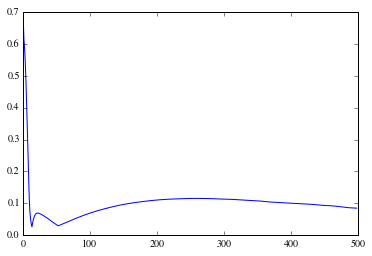

140


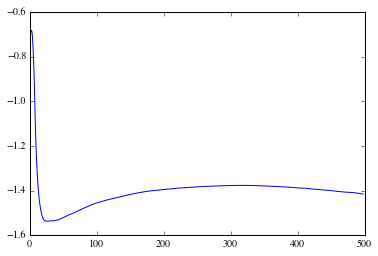

In [121]:
D = 100000000
best_x = 100

Ds = []
alphas = []

for x_min in xrange(10, 5000, 10):
    a, P_ = fit_P(x_min)
    D_cand = ks(S(x_min), P_)
    alphas.append(a)
    Ds.append(D_cand)
    
    if D_cand < D:
        D = D_cand
        best_x = x_min

plt.plot(Ds)
plt.show()
plt.plot(alphas)
print best_x

In [122]:
best_a, _ = fit_P(best_x)

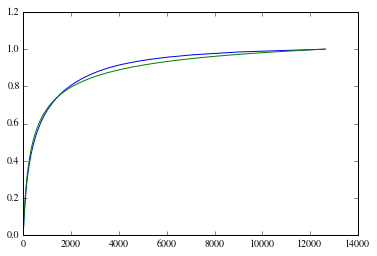

In [119]:
plt.plot(S(best_x))
plt.plot(P(best_x))

In [87]:
np.log(best_x)

4.9416424226093039

In [123]:
a_hat = 1.0 + len(x) / np.sum(np.log(x * 1.0 / best_x))
-a_hat, best_a

(-1.2845976903015646, -1.4030267654499835)

In [114]:
p_hat = x[best_x:] ** (-a_hat)
p_hat = p_hat / p_hat.sum()

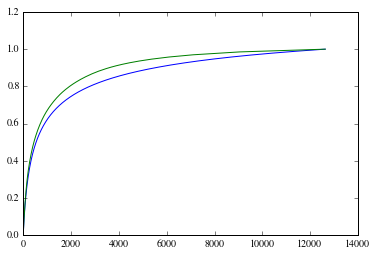

In [124]:
plt.plot(p_hat.cumsum())
plt.plot(S(best_x))

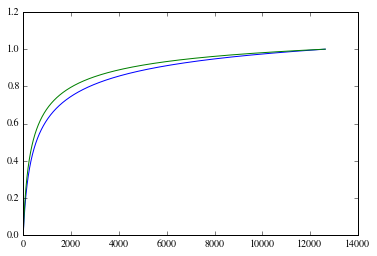

In [125]:
plt.plot(p_hat.cumsum())
plt.plot(P(best_x))

In [127]:
x_min = best_x
fit = sm.OLS(log_px[:x_min], sm.add_constant(log_x[:x_min])).fit()
fit.rsquared

0.86237421164107486

In [128]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     864.7
Date:                Wed, 20 Jan 2016   Prob (F-statistic):           2.71e-61
Time:                        22:14:45   Log-Likelihood:                -108.76
No. Observations:                 140   AIC:                             221.5
Df Residuals:                     138   BIC:                             227.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         -0.4974      0.194     -2.558      0.012        -0.882    -0.113
x1            -1.4030      0.048    -29.406      0.000        -1.497    -1.309
==============================================================================
Omnibus:                        5.857   Durbin-Watson:                   0.034
Prob(Omnibus):                  0.053   Jarque-Bera (JB):                5.699
Skew:                          -0.366   Prob(JB):                       0.0579
Kurtosis:                       3.664   Cond. No.                         18.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [131]:
data = pd.DataFrame(cnt_pd)
data.to_csv('c:/tmp/mlp/ident-count.txt')

In [132]:
from scipy.stats import kstest

In [144]:
ks = kstest(lambda size: S(x_min), lambda size: P(x_min), N=(len(px) - x_min))

In [145]:
ks.pvalue

0.0

Plot

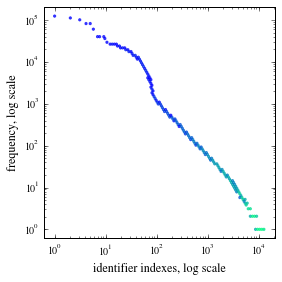

In [220]:
fig = plt.figure(num=None, figsize=(4, 4))
ax = fig.add_subplot(111)

x = log_x
y = np.log(cnt_pd.values)

gridsize = 100
ax.hexbin(x, y, gridsize=gridsize, cmap='winter', reduce_C_function=np.sum, mincnt=1, bins='log', alpha=0.7)

margin = 0.5
ax.axis([x.min()-margin, x.max()+margin, y.min()-margin, y.max()+margin])


from matplotlib.ticker import MultipleLocator, FormatStrFormatter, FixedLocator, FuncFormatter

majorLocator = FixedLocator(np.log([1, 10, 100, 1000, 10000, 100000]))
majorFormatter = FuncFormatter(lambda x, pos: '$10^{%.0f}$' % (x / np.log(10)))
minorLocator = FixedLocator(np.log([1 * x for x in xrange(0, 10)] + \
                                   [10 * x for x in xrange(0, 10)] + \
                                   [100 * x for x in xrange(0, 10)] + \
                                   [1000 * x for x in xrange(0, 10)] + \
                                   [10000 * x for x in xrange(0, 10)]))

ax.xaxis.set_major_locator(majorLocator)
ax.xaxis.set_major_formatter(majorFormatter)
ax.yaxis.set_major_locator(majorLocator)
ax.yaxis.set_major_formatter(majorFormatter)


# for the minor ticks, use no labels; default NullFormatter
ax.xaxis.set_minor_locator(minorLocator)
ax.yaxis.set_minor_locator(minorLocator)
plt.ylabel('frequency, log scale')
plt.xlabel('identifier indexes, log scale')
plt.tight_layout()

plt.savefig('figures/en-wiki-ids-hexbin.pdf', format='pdf')

plt.show()

In [168]:
uniq = np.unique(cnt_pd.values)[::-1]
rank = cnt_pd.apply(lambda x: np.where(x == uniq)[0][0]).values + 1

In [169]:
rank

array([  1,   2,   3, ..., 499, 499, 499], dtype=int64)

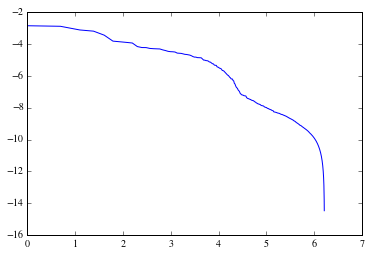

In [170]:
plt.plot(x, y)

[-0.5, 6.7126060957515188, -14.967257451825271, -2.2270848667080951]

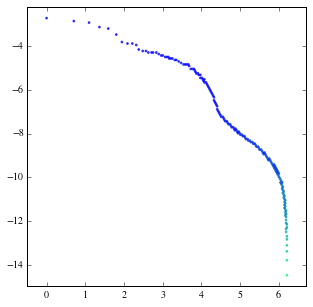

In [172]:
fig = plt.figure(num=None, figsize=(5,5))
ax = fig.add_subplot(111)

x = np.log(rank)
y = np.log(cnt_pd.values) - np.log(cnt_pd.values.sum())

gridsize = 150
ax.hexbin(x, y, gridsize=gridsize, cmap='winter', reduce_C_function=np.sum, mincnt=1, bins='log', alpha=0.7)

margin = 0.5
ax.axis([x.min()-margin, x.max()+margin, y.min()-margin, y.max()+margin])